# Batch Document Extraction with InternVL3-B (Non-Quantized)

This notebook tests non-quantized InternVL3-2B performance on V100 GPUs following the official documentation pattern.

**Testing Purpose**: Now that we've resolved underlying issues (Rich recursion, prompt repetition loops), we're testing whether InternVL3-2B can run without quantization as it did before the problems emerged.

**Official Pattern**: Follows https://internvl.readthedocs.io/en/latest/internvl3.0/quick_start.html

This notebook includes steps for:
* loading documents
* detecting document types  
* extracting relevant information
* generating reports

## 1. Imports

In [1]:
#Cell 1
# Path setup for V100 systems - ensures proper module resolution
import sys
import os
from pathlib import Path
os.environ['EVALUATION_METHOD'] = 'order_aware_f1'  # or 'f1', 'kieval', 'order_aware_f1', 'correlation'


# Get the notebook's directory
notebook_path = Path().absolute()
print(f"📂 Current directory: {notebook_path}")

# Ensure the project root is in the Python path
if str(notebook_path) not in sys.path:
    sys.path.insert(0, str(notebook_path))
    print(f"✅ Added {notebook_path} to sys.path")

# Verify common module can be found
try:
    import common
    print(f"✅ Common module found at: {common.__file__ if hasattr(common, '__file__') else 'built-in'}")
except ImportError as e:
    print(f"❌ Common module not found: {e}")
    print("📋 Current sys.path:")
    for p in sys.path[:5]:  # Show first 5 paths
        print(f"   - {p}")

print("✅ Path setup complete - proceed to imports")

📂 Current directory: /home/jovyan/nfs_share/tod/LMM_POC
✅ Added /home/jovyan/nfs_share/tod/LMM_POC to sys.path
✅ Common module found at: /home/jovyan/nfs_share/tod/LMM_POC/common/__init__.py
✅ Path setup complete - proceed to imports


## 2. Path Setup (V100 Compatibility)

**IMPORTANT**: If you encounter import errors on V100 systems, this cell ensures proper module resolution.

In [2]:
#Cell 2
# Enable autoreload for module changes
%load_ext autoreload
%autoreload 2

# Standard library imports
import sys
import warnings
from datetime import datetime
from pathlib import Path

# Add current directory to path to ensure proper module resolution
# This fixes import issues on multi-GPU V100 setups
notebook_dir = Path.cwd()
if str(notebook_dir) not in sys.path:
    sys.path.insert(0, str(notebook_dir))

# Third-party imports
import numpy as np
import pandas as pd
import torch
from IPython.display import display
from rich import print as rprint
from rich.console import Console
from transformers import AutoModel, AutoTokenizer

# Project-specific imports - using absolute imports to avoid conflicts
from common.batch_analytics import BatchAnalytics
from common.batch_processor import BatchDocumentProcessor
from common.batch_reporting import BatchReporter
from common.batch_visualizations import BatchVisualizer
from common.evaluation_metrics import load_ground_truth
from common.extraction_parser import discover_images
from common.gpu_optimization import emergency_cleanup
from models.document_aware_internvl3_processor import (
    DocumentAwareInternVL3HybridProcessor,
)

print("✅ All imports loaded successfully")
print("✅ InternVL3 Hybrid Processor imported successfully") 
print("✅ Proven batch processing modules imported successfully")
print(f"📂 Working directory: {notebook_dir}")
print("🔬 NON-QUANTIZED MODE: Testing official InternVL3 pattern without quantization")
warnings.filterwarnings('ignore')

DEBUG: field_types_from_yaml = {'monetary': ['GST_AMOUNT', 'TOTAL_AMOUNT', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'boolean': ['IS_GST_INCLUDED'], 'list': ['LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'date': ['INVOICE_DATE', 'STATEMENT_DATE_RANGE', 'TRANSACTION_DATES']}
DEBUG: boolean fields from YAML = ['IS_GST_INCLUDED']
DEBUG: self.boolean_fields = ['IS_GST_INCLUDED']
DEBUG _ensure_fields_loaded: BOOLEAN_FIELDS = ['IS_GST_INCLUDED']
✅ All imports loaded successfully
✅ InternVL3 Hybrid Processor imported successfully
✅ Proven batch processing modules imported successfully
📂 Working directory: /home/jovyan/nfs_share/tod/LMM_POC
🔬 NON-QUANTIZED MODE: Testing official InternVL3 pattern without quantization


## 3. Pre-emptive Memory Cleanup

**CRITICAL for V100**: Run this cell first to prevent OOM errors when switching between models.

In [3]:
#Cell 3
# Pre-emptive V100 Memory Cleanup - Run FIRST to prevent OOM errors
rprint("[bold red]🧹 PRE-EMPTIVE V100 MEMORY CLEANUP[/bold red]")
rprint("[yellow]Clearing any existing model caches before loading...[/yellow]")
rprint("[cyan]💡 This prevents OOM errors when switching between models on V100[/cyan]")

# Emergency cleanup to ensure clean slate
emergency_cleanup(verbose=True)

rprint("[green]✅ Memory cleanup complete - ready for model loading[/green]")
rprint("[dim]📋 Next: Import modules and configure settings[/dim]")

🧹 PRE-EMPTIVE V100 MEMORY CLEANUP

Clearing any existing model caches before loading...

💡 This prevents OOM errors when switching between models on V100

🚨 Running V100 emergency GPU cleanup...
🧹 Starting V100-optimized GPU memory cleanup...
   📊 Initial GPU memory: 0.00GB allocated, 0.00GB reserved
   ✅ Final GPU memory: 0.00GB allocated, 0.00GB reserved
   💾 Memory freed: 0.00GB
✅ V100-optimized memory cleanup complete
✅ V100 emergency cleanup complete


✅ Memory cleanup complete - ready for model loading

📋 Next: Import modules and configure settings

## 4. Configuration

In [4]:
#Cell 4
# Initialize console and environment configuration
console = Console()

# Environment-specific base paths
ENVIRONMENT_BASES = {
    'sandbox': '/home/jovyan/nfs_share/tod/LMM_POC',
    'efs': '/efs/shared/PoC_data'
}
base_data_path = ENVIRONMENT_BASES['sandbox']

CONFIG = {
    # Model settings
    'MODEL_PATH': '/home/jovyan/nfs_share/models/InternVL3-2B', #DANGER WILL ROBINSON
    # 'MODEL_PATH': '/home/jovyan/nfs_share/models/InternVL3-8B',
    # 'MODEL_PATH': '/efs/shared/PTM/InternVL3-2B',
    
    # Batch settings
    'DATA_DIR': f'{base_data_path}/evaluation_data',
    'GROUND_TRUTH': f'{base_data_path}/evaluation_data/ground_truth.csv',
    # 'OUTPUT_BASE': f'{base_data_path}/output',
    'OUTPUT_BASE': f'{base_data_path}/output',
    'MAX_IMAGES': None,  # None for all, or set limit
    'DOCUMENT_TYPES': None,  # None for all, or ['invoice', 'receipt']
    'ENABLE_MATH_ENHANCEMENT': False,  # Disable mathematical correction for bank statements
    
    # Inference and evaluation mode
    'INFERENCE_ONLY': False,  # Default: True (inference-only mode)
    
    # Verbosity control
    'VERBOSE': True,
    'SHOW_PROMPTS': True,
    
    # InternVL3 optimization settings - NON-QUANTIZED TESTING
    # TESTING: Non-quantized performance after bug fixes (Rich recursion, prompt repetition)
    # This follows the official InternVL3 documentation pattern exactly
    'USE_QUANTIZATION': False,  # TESTING: Disabled to test non-quantized performance
    'DEVICE_MAP': 'auto',
    'MAX_NEW_TOKENS': 600,
    'TORCH_DTYPE': 'bfloat16',
    'LOW_CPU_MEM_USAGE': True,
    # Flash Attention: NOT supported on V100, only enable for modern GPUs
    'USE_FLASH_ATTN': False,  # V100 compatible default
    
    # InternVL3-2B TILE CONFIGURATION
    'MAX_TILES': 18,  # InternVL3-2B config default
}

# Make GROUND_TRUTH conditional based on INFERENCE_ONLY mode
if CONFIG['INFERENCE_ONLY']:
    CONFIG['GROUND_TRUTH'] = None

# ============================================================================
# PROMPT CONFIGURATION - Explicit file and key mapping
# ============================================================================
# This configuration controls which prompt files and keys are used for each
# document type. You can explicitly override both the file and the key.
#
# Structure:
#   'extraction_files': Maps document types to YAML prompt files
#   'extraction_keys': (Optional) Maps document types to specific keys in those files
#
# If 'extraction_keys' is not specified for a document type, the key will be
# derived from the document type name (e.g., 'INVOICE' -> 'invoice')
#
# For bank statements, structure classification (_flat or _date_grouped) is 
# automatically appended UNLESS you provide a full key in 'extraction_keys'
# ============================================================================

PROMPT_CONFIG = {
    # Document type detection configuration
    'detection_file': 'prompts/document_type_detection.yaml',
    'detection_key': 'detection',
    
    # Extraction prompt file mapping (REQUIRED)
    'extraction_files': {
        'INVOICE': 'prompts/internvl3_prompts.yaml',
        'RECEIPT': 'prompts/internvl3_prompts.yaml', 
        'BANK_STATEMENT': 'prompts/internvl3_prompts.yaml'
    },
}

# Import field filtering from config to exclude validation-only fields
from common.config import get_v4_field_list, filter_evaluation_fields

# Get universal field list and filter out validation-only fields
# CRITICAL: TRANSACTION_AMOUNTS_RECEIVED and ACCOUNT_BALANCE are excluded
# These fields are only for mathematical validation, not extraction/evaluation
UNIVERSAL_FIELDS = filter_evaluation_fields(get_v4_field_list())

print("✅ Configuration set up successfully")
print(f"📂 Evaluation data: {CONFIG['DATA_DIR']}")
print(f"📊 Ground truth: {CONFIG['GROUND_TRUTH']}")
print(f"🤖 Model path: {CONFIG['MODEL_PATH']}")
print(f"📁 Output base: {CONFIG['OUTPUT_BASE']}")
print(f"📋 Universal fields: {len(UNIVERSAL_FIELDS)} (validation-only fields excluded)")
print(f"🎯 Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}")
print(f"⚙️  Quantization: {'ENABLED (8-bit)' if CONFIG['USE_QUANTIZATION'] else 'DISABLED (full precision)'}")
print(f"⚡ Flash Attention: {'ENABLED' if CONFIG['USE_FLASH_ATTN'] else 'DISABLED (V100 compatible)'}")
print(f"🔲 Max Tiles: {CONFIG['MAX_TILES']} (InternVL3-2B default)")
print("🔬 TESTING: Non-quantized InternVL3 performance after bug fixes")

✅ Configuration set up successfully
📂 Evaluation data: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data
📊 Ground truth: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/ground_truth.csv
🤖 Model path: /home/jovyan/nfs_share/models/InternVL3-2B
📁 Output base: /home/jovyan/nfs_share/tod/LMM_POC/output
📋 Universal fields: 14 (validation-only fields excluded)
🎯 Mode: Evaluation mode
⚙️  Quantization: DISABLED (full precision)
⚡ Flash Attention: DISABLED (V100 compatible)
🔲 Max Tiles: 18 (InternVL3-2B default)
🔬 TESTING: Non-quantized InternVL3 performance after bug fixes


# 5. Output Directory Setup

In [5]:
#Cell 5
# Setup output directories - Handle both absolute and relative paths

# Convert OUTPUT_BASE to Path and handle absolute/relative paths
OUTPUT_BASE = Path(CONFIG['OUTPUT_BASE'])
if not OUTPUT_BASE.is_absolute():
    # If relative, make it relative to current working directory
    OUTPUT_BASE = Path.cwd() / OUTPUT_BASE

BATCH_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

OUTPUT_DIRS = {
    'base': OUTPUT_BASE,
    'batch': OUTPUT_BASE / 'batch_results',
    'csv': OUTPUT_BASE / 'csv',
    'visualizations': OUTPUT_BASE / 'visualizations',
    'reports': OUTPUT_BASE / 'reports'
}

for dir_path in OUTPUT_DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)

# 6. Model Loading (Direct Official Pattern)

**NON-QUANTIZED TESTING**: Loading InternVL3 without quantization using the official documentation pattern to test whether the recent bug fixes (Rich recursion, prompt repetition) resolved the underlying issues.

In [ ]:
#Cell 6
# Load InternVL3 model using DIRECT official pattern (bypassing wrapper)
# https://internvl.readthedocs.io/en/latest/internvl3.0/quick_start.html
rprint("[bold green]Loading InternVL3 model with official NON-QUANTIZED pattern...[/bold green]")
rprint("[cyan]🔬 Testing: Non-quantized performance after bug fixes[/cyan]")
rprint("[cyan]📖 Following: https://internvl.readthedocs.io/en/latest/internvl3.0/quick_start.html[/cyan]")

try:
    # Clear any existing CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        rprint("[blue]🧹 CUDA cache cleared[/blue]")
    
    # Load model using exact official pattern
    rprint("[cyan]📥 Loading model with official parameters...[/cyan]")
    model = AutoModel.from_pretrained(
        CONFIG['MODEL_PATH'],
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True,
        use_flash_attn=False,  # V100 compatible
        trust_remote_code=True,
        device_map="auto"  # Distribute across available GPUs
    ).eval()
    
    # Load tokenizer
    rprint("[cyan]📥 Loading tokenizer...[/cyan]")
    tokenizer = AutoTokenizer.from_pretrained(
        CONFIG['MODEL_PATH'],
        trust_remote_code=True,
        use_fast=False
    )
    
    # Set generation parameters
    model.config.max_new_tokens = CONFIG['MAX_NEW_TOKENS']
    
    # Display model information
    rprint("[green]✅ Model and tokenizer loaded successfully![/green]")
    
    # GPU memory check
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        total = torch.cuda.get_device_properties(0).total_memory / 1e9
        rprint(f"[blue]📊 GPU Memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved, {total:.0f}GB total[/blue]")
        rprint(f"[blue]🔍 Memory usage: {(allocated/total*100):.1f}%[/blue]")
    
    # Model parameters
    param_count = sum(p.numel() for p in model.parameters())
    rprint(f"[blue]🔢 Model parameters: {param_count:,}[/blue]")
    rprint(f"[blue]🎯 Data type: {model.dtype}[/blue]")
    rprint(f"[blue]🖥️  Device: {next(model.parameters()).device}[/blue]")
    
    # Add device map diagnostic
    if hasattr(model, 'hf_device_map'):
        from collections import Counter
        device_distribution = Counter(model.hf_device_map.values())
        rprint(f"[blue]🔄 Model distribution: {dict(device_distribution)}[/blue]")
    else:
        rprint("[blue]📍 No device map found - model placed manually[/blue]")
    
    # Initialize the hybrid processor with loaded model components
    rprint("[cyan]🔧 Initializing document-aware processor...[/cyan]")
    hybrid_processor = DocumentAwareInternVL3HybridProcessor(
        field_list=UNIVERSAL_FIELDS,
        model_path=CONFIG['MODEL_PATH'],
        debug=CONFIG['VERBOSE'],
        pre_loaded_model=model,
        pre_loaded_tokenizer=tokenizer,
        prompt_config=PROMPT_CONFIG,  # Single source of truth for configuration!
        max_tiles=CONFIG['MAX_TILES']  # InternVL3-2B optimized tile configuration
    )
    
    rprint("[bold green]✅ InternVL3 NON-QUANTIZED model ready for document-aware processing[/bold green]")
    rprint(f"[cyan]🔲 Using {CONFIG['MAX_TILES']} tiles (InternVL3-2B default)[/cyan]")    
except Exception as e:
    rprint(f"[red]❌ Error loading model: {e}[/red]")
    rprint("[yellow]💡 This may indicate that quantization is still required for V100 GPUs[/yellow]")
    raise

Loading InternVL3 model with official NON-QUANTIZED pattern...

🔬 Testing: Non-quantized performance after bug fixes

📖 Following: https://internvl.readthedocs.io/en/latest/internvl3.0/quick_start.html

🧹 CUDA cache cleared

📥 Loading model with official parameters...

FlashAttention2 is not installed.


📥 Loading tokenizer...

✅ Model and tokenizer loaded successfully!

📊 GPU Memory: 2.29GB allocated, 2.42GB reserved, 48GB total

🔍 Memory usage: 4.8%

🔢 Model parameters: 2,088,957,440

🎯 Data type: torch.bfloat16

🖥️  Device: cuda:0

🔄 Model distribution: {0: 15, 1: 19}

🔧 Initializing document-aware processor...

🎯 InternVL3 Hybrid processor initialized for 14 fields: DOCUMENT_TYPE → TOTAL_AMOUNT
🔧 CUDA memory allocation configured: max_split_size_mb:64
💡 Using 64MB memory blocks to reduce fragmentation
📊 Initial CUDA state (Multi-GPU Total): Allocated=3.89GB, Reserved=4.11GB
🤖 Auto-detected batch size: 8 (GPU Memory: 84.9GB)
🎯 DOCUMENT AWARE REDUCTION: 14 fields (~52% fewer than original 29)
🎯 Generation config: max_new_tokens=2000, do_sample=False (greedy decoding)
✅ Using pre-loaded InternVL3 model and tokenizer
🔧 Device: cuda:0
💾 Model parameters: 2,088,957,440
🚀 V100 optimizations applied


✅ InternVL3 NON-QUANTIZED model ready for document-aware processing

🔲 Using 18 tiles (InternVL3-2B default)

🔬 If you see gibberish responses, it confirms quantization is still needed for V100

🎉 If responses are clean, it proves the bug fixes resolved the core issues!

# 7. Image Discovery

In [7]:
#Cell 7
# Discover and filter images - Handle both absolute and relative paths

# Convert DATA_DIR to Path and handle absolute/relative paths
data_dir = Path(CONFIG['DATA_DIR'])
if not data_dir.is_absolute():
    # If relative, make it relative to current working directory
    data_dir = Path.cwd() / data_dir

# Discover images from the resolved data directory
all_images = discover_images(str(data_dir))

# Conditionally load ground truth only when not in inference-only mode
ground_truth = {}
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    # Convert GROUND_TRUTH to Path and handle absolute/relative paths
    ground_truth_path = Path(CONFIG['GROUND_TRUTH'])
    if not ground_truth_path.is_absolute():
        # If relative, make it relative to current working directory
        ground_truth_path = Path.cwd() / ground_truth_path
    
    # Load ground truth from the resolved path
    ground_truth = load_ground_truth(str(ground_truth_path), verbose=CONFIG['VERBOSE'])
    
    rprint(f"[green]✅ Ground truth loaded for {len(ground_truth)} images[/green]")
else:
    rprint("[cyan]📋 Running in inference-only mode (no ground truth required)[/cyan]")

# Apply filters (only if ground truth is available)
if CONFIG['DOCUMENT_TYPES'] and ground_truth:
    filtered = []
    for img in all_images:
        img_name = Path(img).name
        if img_name in ground_truth:
            doc_type = ground_truth[img_name].get('DOCUMENT_TYPE', '').lower()
            if any(dt.lower() in doc_type for dt in CONFIG['DOCUMENT_TYPES']):
                filtered.append(img)
    all_images = filtered

if CONFIG['MAX_IMAGES']:
    all_images = all_images[:CONFIG['MAX_IMAGES']]

rprint(f"[bold green]Ready to process {len(all_images)} images[/bold green]")
rprint(f"[cyan]Data directory: {data_dir}[/cyan]")
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    rprint(f"[cyan]Ground truth: {ground_truth_path}[/cyan]")
rprint(f"[cyan]Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}[/cyan]")
for i, img in enumerate(all_images[:5], 1):
    print(f"  {i}. {Path(img).name}")
if len(all_images) > 5:
    print(f"  ... and {len(all_images) - 5} more")

📊 Ground truth CSV loaded with 19 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 19 images


✅ Ground truth loaded for 19 images

Ready to process 19 images

Data directory: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data

Ground truth: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/ground_truth.csv

Mode: Evaluation mode

  1. cba_amount_balance.png
  2. cba_date_grouped.png
  3. cba_date_grouped_cont.png
  4. cba_debit_credit.png
  5. cba_highligted.png
  ... and 14 more


## 8. Batch Processing

In [8]:
#Cell 8
# Initialize batch processor with proven infrastructure (same pattern as llama_batch.ipynb)
processor = BatchDocumentProcessor(
    model=hybrid_processor,  # InternVL3 hybrid processor (handler)
    processor=None,          # Not needed for InternVL3
    prompt_config=PROMPT_CONFIG,
    ground_truth_csv=CONFIG['GROUND_TRUTH'],  # None in inference-only mode
    console=console,
    enable_math_enhancement=CONFIG['ENABLE_MATH_ENHANCEMENT']
)

# Process batch using proven evaluation infrastructure
batch_results, processing_times, document_types_found = processor.process_batch(
    all_images, verbose=CONFIG['VERBOSE']
)

# Brief summary
rprint(f"[bold green]✅ Processed {len(batch_results)} images[/bold green]")
rprint(f"[cyan]Average time: {np.mean(processing_times):.2f}s[/cyan]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Inference-only mode: No accuracy evaluation performed[/cyan]")
else:
    avg_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in batch_results if 'evaluation' in r])
    rprint(f"[cyan]Average accuracy: {avg_accuracy:.1f}%[/cyan]")

📊 Ground truth CSV loaded with 19 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 19 images


✅ Loaded ground truth for 19 images

📋 Sample GT keys: ['cba_date_grouped.png', 'cba_date_grouped_cont.png', 'transaction_summary.png']

🚀 Starting Batch Processing

──────────────────────────────────────────────── Batch Extraction ─────────────────────────────────────────────────

Output()

Processing [1/19]: cba_amount_balance.png

🔍 TRACE: Processing InternVL3 image 1/19: cba_amount_balance.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([13, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 0/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for cba_amount_balance.png, doc_type=INVOICE

✓ Extracted 0 fields from cba_amount_balance.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'NOT_FOUND' (type: str)

Are they equal? True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 85.7% for cba_amount_balance.png

  Precision: 85.7% | Recall: 85.7%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [2/19]: cba_date_grouped.png

🔍 TRACE: Processing InternVL3 image 2/19: cba_date_grouped.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([16, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 2.16GB allocated, 2.29GB reserved

✅ Final GPU memory: 2.16GB allocated, 2.29GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 0/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for cba_date_grouped.png, doc_type=INVOICE

✓ Extracted 0 fields from cba_date_grouped.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'NOT_FOUND' (type: str)

Are they equal? True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 71.4% for cba_date_grouped.png

  Precision: 71.4% | Recall: 71.4%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [3/19]: cba_date_grouped_cont.png

🔍 TRACE: Processing InternVL3 image 3/19: cba_date_grouped_cont.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 2.15GB allocated, 2.29GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 0/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for cba_date_grouped_cont.png, doc_type=INVOICE

✓ Extracted 0 fields from cba_date_grouped_cont.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'NOT_FOUND' (type: str)

Are they equal? True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 71.4% for cba_date_grouped_cont.png

  Precision: 71.4% | Recall: 71.4%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [4/19]: cba_debit_credit.png

🔍 TRACE: Processing InternVL3 image 4/19: cba_debit_credit.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 2.15GB allocated, 2.29GB reserved

✅ Final GPU memory: 2.15GB allocated, 2.29GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 0/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for cba_debit_credit.png, doc_type=INVOICE

✓ Extracted 0 fields from cba_debit_credit.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'NOT_FOUND' (type: str)

Are they equal? True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 85.7% for cba_debit_credit.png

  Precision: 85.7% | Recall: 85.7%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [5/19]: cba_highligted.png

🔍 TRACE: Processing InternVL3 image 5/19: cba_highligted.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([17, 3, 448, 448]) (batch_size=17 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([17, 3, 448, 448]) (batch_size=17 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([17, 3, 448, 448]) (batch_size=17 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([17, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 2.16GB allocated, 2.29GB reserved

✅ Final GPU memory: 2.16GB allocated, 2.29GB reserved

✅ Extracted 0/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for cba_highligted.png, doc_type=INVOICE

✓ Extracted 0 fields from cba_highligted.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'NOT_FOUND' (type: str)

Are they equal? True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 78.6% for cba_highligted.png

  Precision: 78.6% | Recall: 78.6%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

[5/19] cba_highligted.png: INVOICE - Accuracy: 78.6% - Time: 3.48s

Processing [6/19]: cba_home_loan.png

🔍 TRACE: Processing InternVL3 image 6/19: cba_home_loan.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([13, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 2.16GB allocated, 2.28GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 0/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for cba_home_loan.png, doc_type=INVOICE

✓ Extracted 0 fields from cba_home_loan.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'NOT_FOUND' (type: str)

Are they equal? True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 78.6% for cba_home_loan.png

  Precision: 78.6% | Recall: 78.6%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [7/19]: image_001.png

🔍 TRACE: Processing InternVL3 image 7/19: image_001.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 2.15GB allocated, 2.29GB reserved

✅ Final GPU memory: 2.15GB allocated, 2.29GB reserved

✅ Extracted 0/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_001.png, doc_type=INVOICE

✓ Extracted 0 fields from image_001.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 0.0% for image_001.png

  Precision: 0.0% | Recall: 0.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [8/19]: image_002.png

🔍 TRACE: Processing InternVL3 image 8/19: image_002.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 2.15GB allocated, 2.29GB reserved

✅ Final GPU memory: 2.15GB allocated, 2.29GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 0/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_002.png, doc_type=INVOICE

✓ Extracted 0 fields from image_002.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 0.0% for image_002.png

  Precision: 0.0% | Recall: 0.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [9/19]: image_003.png

🔍 TRACE: Processing InternVL3 image 9/19: image_003.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([13, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Extracted 0/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_003.png, doc_type=INVOICE

✓ Extracted 0 fields from image_003.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'NOT_FOUND' (type: str)

Are they equal? True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 71.4% for image_003.png

  Precision: 71.4% | Recall: 71.4%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [10/19]: image_004.png

🔍 TRACE: Processing InternVL3 image 10/19: image_004.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 2.15GB allocated, 2.29GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 0/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_004.png, doc_type=INVOICE

✓ Extracted 0 fields from image_004.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 0.0% for image_004.png

  Precision: 0.0% | Recall: 0.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

[10/19] image_004.png: INVOICE - Accuracy: 0.0% - Time: 1.82s

Processing [11/19]: image_005.png

🔍 TRACE: Processing InternVL3 image 11/19: image_005.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([13, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 0/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_005.png, doc_type=INVOICE

✓ Extracted 0 fields from image_005.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 0.0% for image_005.png

  Precision: 0.0% | Recall: 0.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [12/19]: image_006.png

🔍 TRACE: Processing InternVL3 image 12/19: image_006.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([17, 3, 448, 448]) (batch_size=17 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([17, 3, 448, 448]) (batch_size=17 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([17, 3, 448, 448]) (batch_size=17 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([17, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 0/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_006.png, doc_type=INVOICE

✓ Extracted 0 fields from image_006.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 0.0% for image_006.png

  Precision: 0.0% | Recall: 0.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [13/19]: image_007.png

🔍 TRACE: Processing InternVL3 image 13/19: image_007.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 2.15GB allocated, 2.29GB reserved

✅ Final GPU memory: 2.15GB allocated, 2.29GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 0/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_007.png, doc_type=INVOICE

✓ Extracted 0 fields from image_007.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 0.0% for image_007.png

  Precision: 0.0% | Recall: 0.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [14/19]: image_008.png

🔍 TRACE: Processing InternVL3 image 14/19: image_008.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 2.15GB allocated, 2.29GB reserved

✅ Final GPU memory: 2.15GB allocated, 2.29GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 0/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_008.png, doc_type=INVOICE

✓ Extracted 0 fields from image_008.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'NOT_FOUND' (type: str)

Are they equal? True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 71.4% for image_008.png

  Precision: 71.4% | Recall: 71.4%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [15/19]: image_009.png

🔍 TRACE: Processing InternVL3 image 15/19: image_009.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Extracted 0/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_009.png, doc_type=INVOICE

✓ Extracted 0 fields from image_009.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'NOT_FOUND' (type: str)

Are they equal? True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 71.4% for image_009.png

  Precision: 71.4% | Recall: 71.4%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

[15/19] image_009.png: INVOICE - Accuracy: 71.4% - Time: 1.81s

Processing [16/19]: low_contrast.png

🔍 TRACE: Processing InternVL3 image 16/19: low_contrast.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([13, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 2.16GB allocated, 2.28GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 0/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for low_contrast.png, doc_type=INVOICE

✓ Extracted 0 fields from low_contrast.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'NOT_FOUND' (type: str)

Are they equal? True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 85.7% for low_contrast.png

  Precision: 85.7% | Recall: 85.7%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [17/19]: nab_classic_highligted.png

🔍 TRACE: Processing InternVL3 image 17/19: nab_classic_highligted.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([16, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Extracted 0/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for nab_classic_highligted.png, doc_type=INVOICE

✓ Extracted 0 fields from nab_classic_highligted.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'NOT_FOUND' (type: str)

Are they equal? True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 71.4% for nab_classic_highligted.png

  Precision: 71.4% | Recall: 71.4%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [18/19]: transaction_summary.png

🔍 TRACE: Processing InternVL3 image 18/19: transaction_summary.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([16, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 2.16GB allocated, 2.29GB reserved

✅ Final GPU memory: 2.16GB allocated, 2.29GB reserved

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 0/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for transaction_summary.png, doc_type=INVOICE

✓ Extracted 0 fields from transaction_summary.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'NOT_FOUND' (type: str)

Are they equal? True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 85.7% for transaction_summary.png

  Precision: 85.7% | Recall: 85.7%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [19/19]: westpac_debit_credit.png

🔍 TRACE: Processing InternVL3 image 19/19: westpac_debit_credit.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

🤖 Model response:

🔍 PARSING DEBUG - Raw response: ''

🔍 PARSING DEBUG - Cleaned response: ''

❌ PARSING DEBUG - No matches found, using fallback: 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': '', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=18, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([16, 3, 448, 448])

💭 Generating with max_new_tokens=2000

❌ CRITICAL: Generation failed with exception: Expected all tensors to be on the same device, but found at least 
two devices, cuda:1 and cuda:0!

Exception type: RuntimeError

Traceback (most recent call last):

File "/home/jovyan/nfs_share/tod/LMM_POC/models/document_aware_internvl3_processor.py", line 818, in 
_resilient_generate
    response = self.model.chat(
               ^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
291, in chat
    generation_output = self.generate(
                        ^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.cache/huggingface/modules/transformers_modules/InternVL3-2B/modeling_internvl_chat.py", line 
340, in generate
    outputs = self.language_model.generate(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

File "/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/torch/utils/_contextlib.py",
line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 2047, in generate
    result = self._sample(
             ^^^^^^^^^^^^^

File 
"/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/transformers/generation/utils.py", 
line 3049, in _sample
    next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)
                  ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

📄 RAW MODEL RESPONSE (0 chars):

================================================================================

================================================================================

📊 PARSED EXTRACTION RESULTS:

================================================================================

❌ DOCUMENT_TYPE: "NOT_FOUND"

❌ BUSINESS_ABN: "NOT_FOUND"

❌ SUPPLIER_NAME: "NOT_FOUND"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

❌ PAYER_NAME: "NOT_FOUND"

❌ PAYER_ADDRESS: "NOT_FOUND"

❌ INVOICE_DATE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

❌ LINE_ITEM_PRICES: "NOT_FOUND"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

❌ IS_GST_INCLUDED: "NOT_FOUND"

❌ GST_AMOUNT: "NOT_FOUND"

❌ TOTAL_AMOUNT: "NOT_FOUND"

================================================================================

✅ Extracted 0/14 fields

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for westpac_debit_credit.png, doc_type=INVOICE

✓ Extracted 0 fields from westpac_debit_credit.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'NOT_FOUND' (type: str)

Are they equal? True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 78.6% for westpac_debit_credit.png

  Precision: 78.6% | Recall: 78.6%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

[19/19] westpac_debit_credit.png: INVOICE - Accuracy: 78.6% - Time: 3.02s

──────────────────────────────────────────── Batch Processing Complete ────────────────────────────────────────────

✅ Processed 19 images

Average time: 2.68s

Average accuracy: 53.0%

## 9. Generate Analytics

In [9]:
#Cell 9
# Create model-specific CSV file to match Llama structure
# Define all field columns that should be in the CSV (matching Llama)
FIELD_COLUMNS = [
    'DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 
    'PAYER_NAME', 'PAYER_ADDRESS', 'INVOICE_DATE', 'LINE_ITEM_DESCRIPTIONS',
    'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES',
    'IS_GST_INCLUDED', 'GST_AMOUNT', 'TOTAL_AMOUNT', 'STATEMENT_DATE_RANGE',
    'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED',
    'ACCOUNT_BALANCE'
]

# Create comprehensive results data matching Llama structure
internvl3_csv_data = []

for i, result in enumerate(batch_results):
    # Basic metadata
    image_name = Path(result['image_path']).name
    doc_type = result.get('document_type', '').lower()
    processing_time = processing_times[i] if i < len(processing_times) else 0
    
    # Extract fields from result
    extraction_result = result.get('extraction_result', {})
    extracted_fields = extraction_result.get('extracted_data', {})
    accuracy_data = result.get('evaluation', {})
    
    # Count fields
    total_fields = len(FIELD_COLUMNS)
    found_fields = sum(1 for field in FIELD_COLUMNS if extracted_fields.get(field, 'NOT_FOUND') != 'NOT_FOUND')
    field_coverage = (found_fields / total_fields * 100) if total_fields > 0 else 0
    
    # Handle both inference-only and evaluation modes
    if CONFIG['INFERENCE_ONLY'] or accuracy_data.get('inference_only', False):
        # Inference-only mode
        overall_accuracy = None
        fields_extracted = found_fields
        fields_matched = 0  # No matching in inference mode
        eval_total_fields = total_fields
    else:
        # Evaluation mode
        overall_accuracy = accuracy_data.get('overall_accuracy', 0) * 100 if accuracy_data else 0
        fields_extracted = accuracy_data.get('fields_extracted', 0) if accuracy_data else 0
        fields_matched = accuracy_data.get('fields_matched', 0) if accuracy_data else 0
        eval_total_fields = accuracy_data.get('total_fields', total_fields) if accuracy_data else total_fields
    
    # Create prompt identifier (mark as non-quantized)
    prompt_used = f"internvl3_non_quantized_{doc_type}" if doc_type else "internvl3_non_quantized_unknown"
    
    # Create row data
    row_data = {
        'image_file': image_name,
        'image_name': image_name,
        'document_type': doc_type,
        'processing_time': processing_time,
        'field_count': eval_total_fields,
        'found_fields': fields_extracted,
        'field_coverage': field_coverage,
        'prompt_used': prompt_used,
        'timestamp': datetime.now().isoformat(),
        'overall_accuracy': overall_accuracy,
        'fields_extracted': fields_extracted,
        'fields_matched': fields_matched,
        'total_fields': eval_total_fields,
        'inference_only': CONFIG['INFERENCE_ONLY'],
        'quantization_used': False  # Mark as non-quantized
    }
    
    # Add all field values
    for field in FIELD_COLUMNS:
        row_data[field] = extracted_fields.get(field, 'NOT_FOUND')
    
    internvl3_csv_data.append(row_data)

# Create DataFrame and save
internvl3_df = pd.DataFrame(internvl3_csv_data)
internvl3_csv_path = OUTPUT_DIRS['csv'] / f"internvl3_non_quantized_batch_results_{BATCH_TIMESTAMP}.csv"
internvl3_df.to_csv(internvl3_csv_path, index=False)

rprint("[bold green]✅ InternVL3 NON-QUANTIZED model-specific CSV exported:[/bold green]")
rprint(f"[cyan]📄 File: {internvl3_csv_path}[/cyan]")
rprint(f"[cyan]📊 Structure: {len(internvl3_df)} rows × {len(internvl3_df.columns)} columns[/cyan]")
rprint("[cyan]🔗 Compatible with model_comparison.ipynb pattern: *internvl3*non*quantized*batch*results*.csv[/cyan]")

# Display sample of the exported data (conditional based on mode)
if CONFIG['INFERENCE_ONLY']:
    rprint("\n[bold blue]📋 Sample exported data (inference-only mode):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'processing_time', 'found_fields', 'field_coverage', 'quantization_used']
    if len(internvl3_df) > 0:
        display(internvl3_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")
else:
    rprint("\n[bold blue]📋 Sample exported data (first 3 rows, key columns):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'overall_accuracy', 'processing_time', 'found_fields', 'quantization_used']
    if len(internvl3_df) > 0:
        display(internvl3_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")

    # Verification: Show accuracy values to confirm they're correct (evaluation mode only)
    rprint("\n[bold blue]🔍 Accuracy verification:[/bold blue]")
    for i, result in enumerate(batch_results[:3]):  # Show first 3
        evaluation = result.get('evaluation', {})
        original_accuracy = evaluation.get('overall_accuracy', 0)
        percentage_accuracy = original_accuracy * 100
        rprint(f"  {result['image_name']}: {original_accuracy:.4f} → {percentage_accuracy:.2f}%")

# Create analytics using proven infrastructure (same pattern as llama_batch.ipynb)
analytics = BatchAnalytics(batch_results, processing_times)

# Generate and save DataFrames using established patterns
saved_files, df_results, df_summary, df_doctype_stats, df_field_stats = analytics.save_all_dataframes(
    OUTPUT_DIRS['csv'], BATCH_TIMESTAMP, verbose=CONFIG['VERBOSE']
)

# Display key results based on mode
rprint("\n[bold blue]📊 InternVL3 NON-QUANTIZED Results Summary[/bold blue]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Running in inference-only mode - no accuracy metrics available[/cyan]")
    # Show extraction statistics instead
    rprint(f"[cyan]✅ Total images processed: {len(batch_results)}[/cyan]")
    rprint(f"[cyan]✅ Average fields found: {internvl3_df['found_fields'].mean():.1f}[/cyan]")
    rprint(f"[cyan]✅ Average field coverage: {internvl3_df['field_coverage'].mean():.1f}%[/cyan]")
else:
    display(df_summary)

✅ InternVL3 NON-QUANTIZED model-specific CSV exported:

📄 File: /home/jovyan/nfs_share/tod/LMM_POC/output/csv/internvl3_non_quantized_batch_results_20251125_215146.csv

📊 Structure: 19 rows × 34 columns

🔗 Compatible with model_comparison.ipynb pattern: *internvl3*non*quantized*batch*results*.csv

📋 Sample exported data (first 3 rows, key columns):

,image_file,document_type,overall_accuracy,processing_time,found_fields,quantization_used
0,cba_amount_balance.png,invoice,85.714286,5.492457,0,False
1,cba_date_grouped.png,invoice,71.428571,3.209073,0,False
2,cba_date_grouped_cont.png,invoice,71.428571,2.459162,0,False


🔍 Accuracy verification:

cba_amount_balance.png: 0.8571 → 85.71%

cba_date_grouped.png: 0.7143 → 71.43%

cba_date_grouped_cont.png: 0.7143 → 71.43%

✅ DataFrames saved to /home/jovyan/nfs_share/tod/LMM_POC/output/csv

📊 InternVL3 NON-QUANTIZED Results Summary

,Value
Total Images,19.000000
Successful Extractions,19.000000
Failed Extractions,0.000000
Average Accuracy (%),53.007519
Median Accuracy (%),71.428571
Min Accuracy (%),0.000000
Max Accuracy (%),85.714286
Average Processing Time (s),2.681084
Total Processing Time (s),50.940599
Throughput (images/min),22.379006


## 10. Export Model-Specific CSV for Comparison

Create InternVL3 NON-QUANTIZED specific CSV file that matches Llama structure for model comparison:

In [10]:
#Cell 10
# Create visualizations using proven infrastructure (same pattern as llama_batch.ipynb)
visualizer = BatchVisualizer()

viz_files = visualizer.create_all_visualizations(
    df_results, 
    df_doctype_stats,
    OUTPUT_DIRS['visualizations'],
    BATCH_TIMESTAMP,
    show=False  # Disable display to reduce output
)

✅ Dashboard saved to /home/jovyan/nfs_share/tod/LMM_POC/output/visualizations/dashboard_20251125_215146.png

⚠️ No field-level accuracy data available

## 11. Generate Reports

In [11]:
#Cell 11
# Generate reports using proven infrastructure (same pattern as llama_batch.ipynb)
reporter = BatchReporter(
    batch_results, 
    processing_times,
    document_types_found,
    BATCH_TIMESTAMP
)

# Save all reports using CONFIG verbose setting
report_files = reporter.save_all_reports(
    OUTPUT_DIRS,
    df_results,
    df_summary,
    df_doctype_stats,
    CONFIG['MODEL_PATH'],
    {
        'data_dir': CONFIG['DATA_DIR'],
        'ground_truth': CONFIG['GROUND_TRUTH'],
        'max_images': CONFIG['MAX_IMAGES'],
        'document_types': CONFIG['DOCUMENT_TYPES']
    },
    {
        'use_quantization': CONFIG['USE_QUANTIZATION'],
        'device_map': CONFIG['DEVICE_MAP'],
        'max_new_tokens': CONFIG['MAX_NEW_TOKENS'],
        'torch_dtype': CONFIG['TORCH_DTYPE'],
        'low_cpu_mem_usage': CONFIG['LOW_CPU_MEM_USAGE']
    },
    verbose=CONFIG['VERBOSE']
)

✅ Executive summary saved to /home/jovyan/nfs_share/tod/LMM_POC/output/reports/batch_report_20251125_215146.md

✅ Complete results exported to 
/home/jovyan/nfs_share/tod/LMM_POC/output/batch_results/batch_results_20251125_215146.json

## 12. Display Final Summary

──────────────────────────────── InternVL3 NON-QUANTIZED Batch Processing Complete ────────────────────────────────

✅ Processed: 19 images

Success Rate: 100.0%

Overall Average Accuracy (across all images): 53.01%

📊 Breakdown by Document Type:

  INVOICE: 53.0% (n=19 images)

Output: /home/jovyan/nfs_share/tod/LMM_POC/output

🔬 QUANTIZATION: DISABLED (testing non-quantized performance)

🎉 SUCCESS: Non-quantized InternVL3 appears to be working correctly!

✅ This proves the bug fixes (Rich recursion, prompt repetition) resolved the core issues

✅ InternVL3-2B can run without quantization as it did before the problems emerged

📋 Document Type Distribution:

  INVOICE: 19 documents (100.0%)

📊 Visual Dashboard:

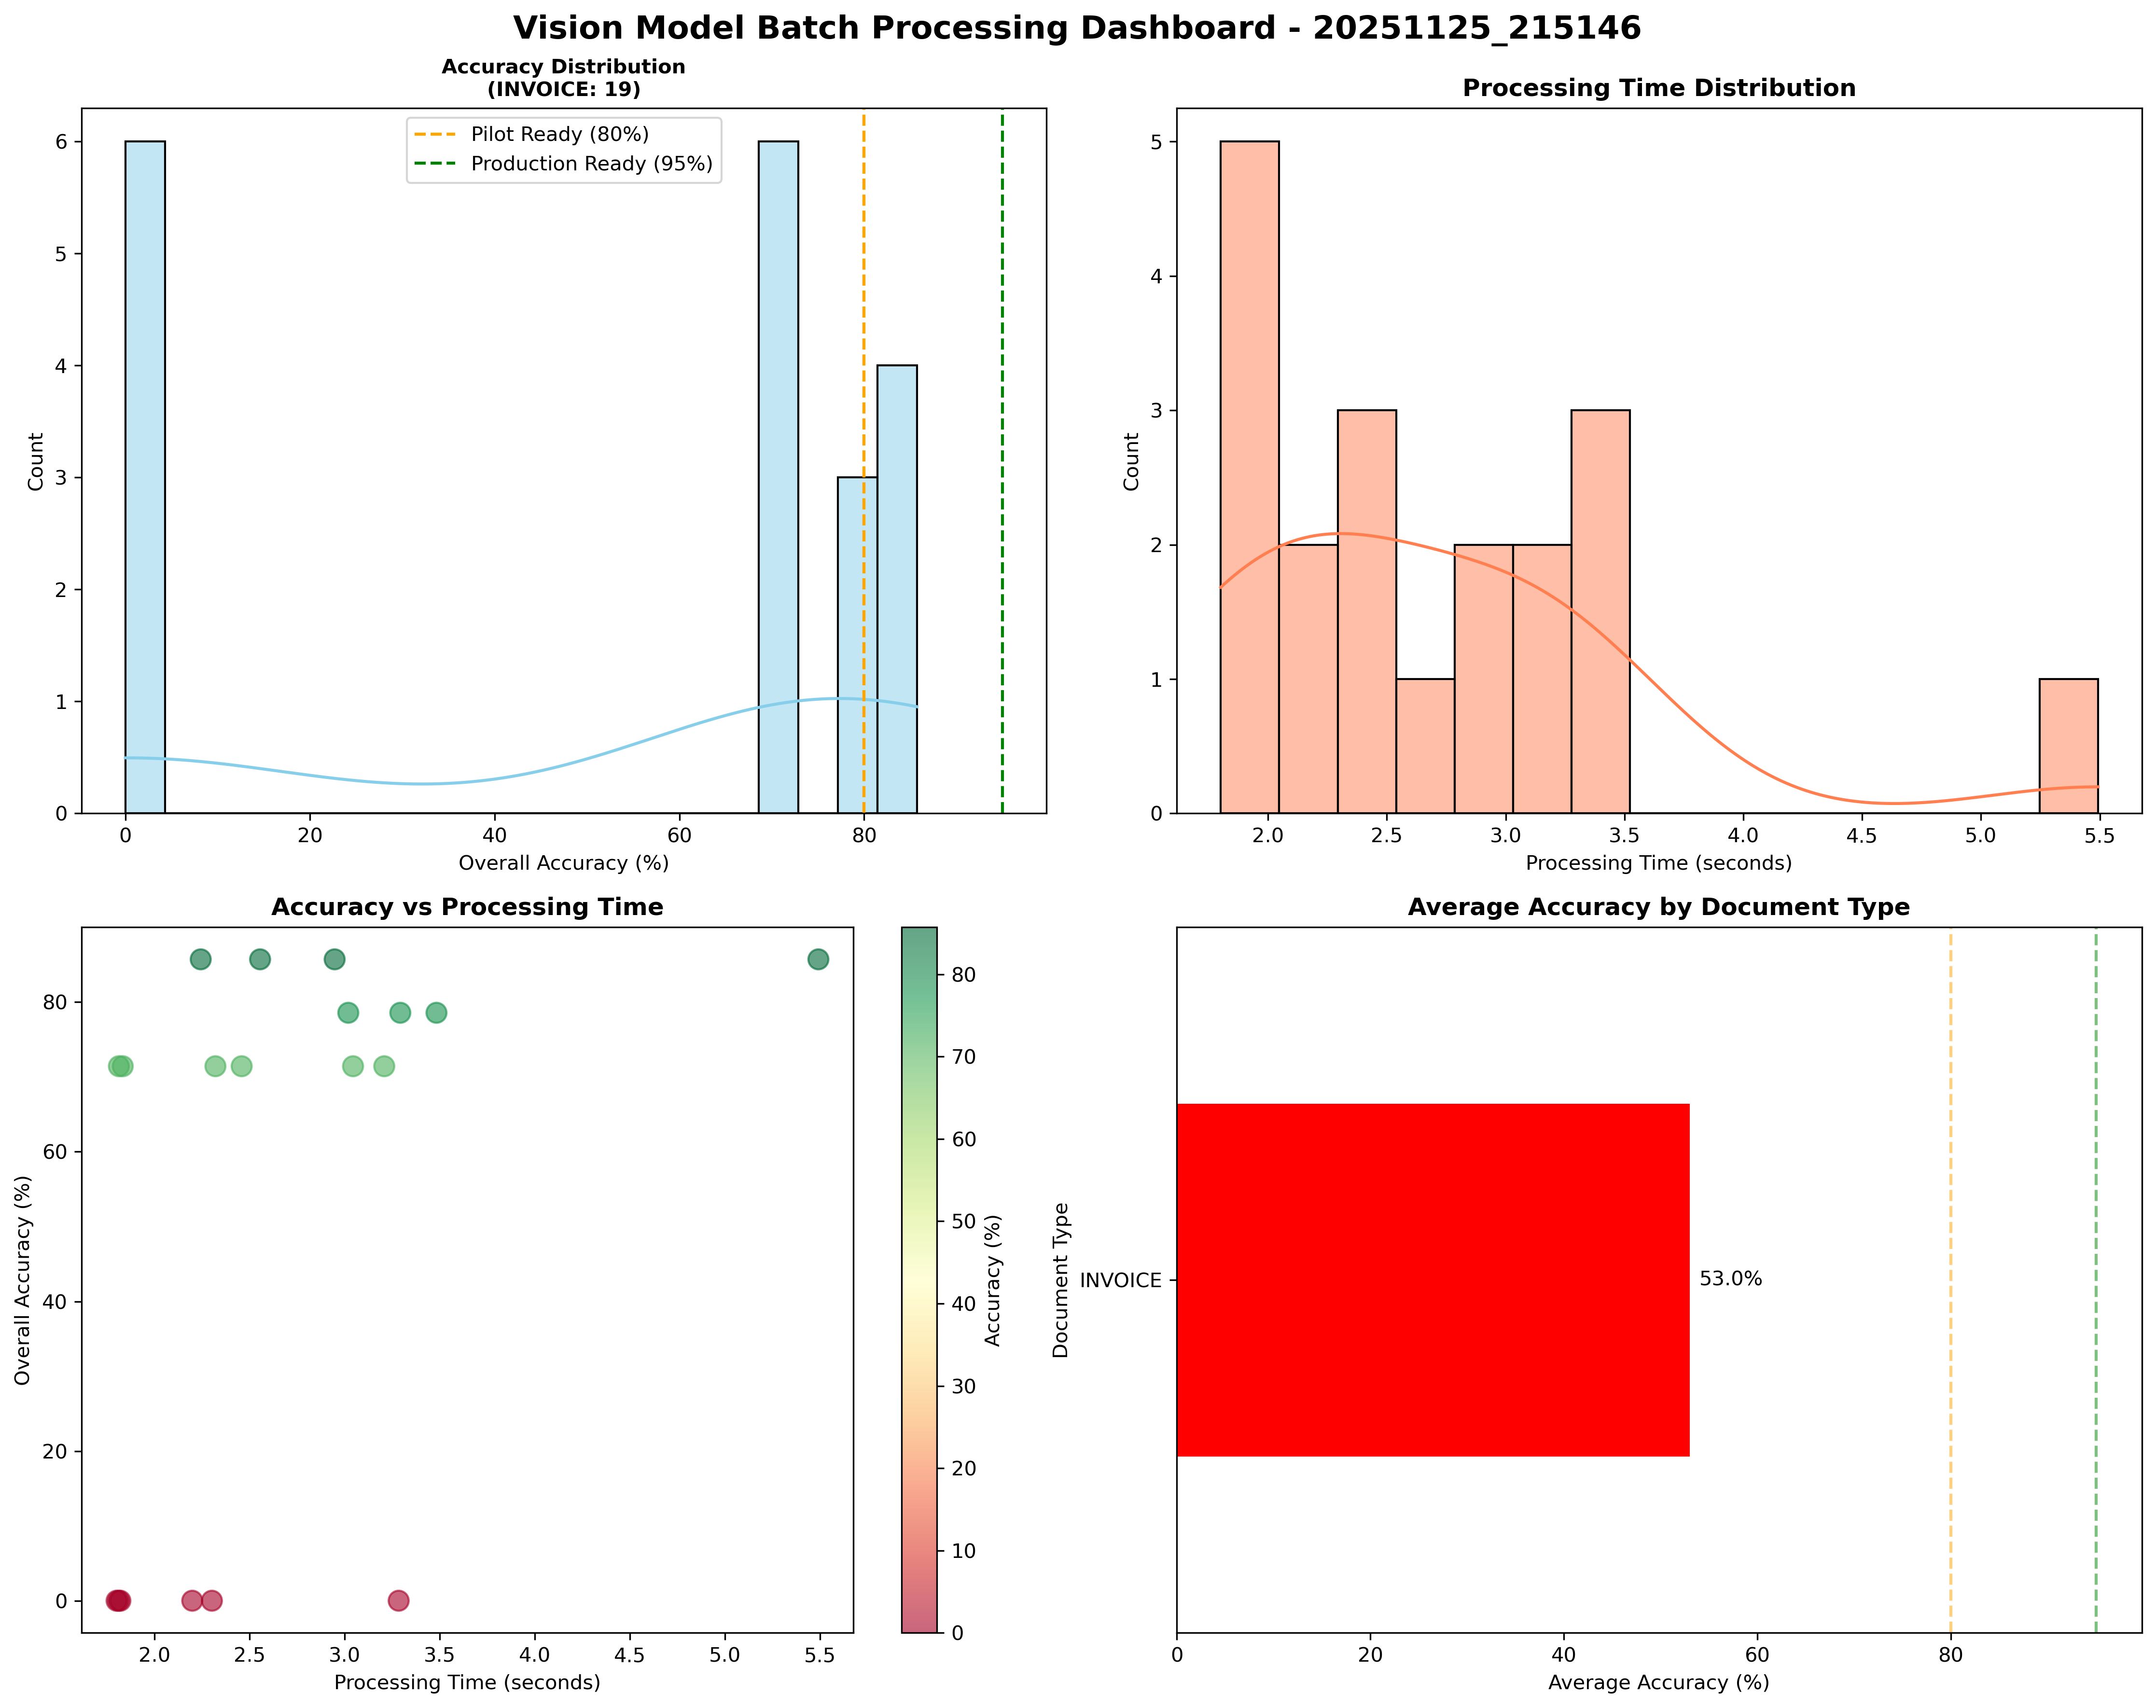

In [12]:
#Cell 12
# Display final summary
console.rule("[bold green]InternVL3 NON-QUANTIZED Batch Processing Complete[/bold green]")

total_images = len(batch_results)
successful = len([r for r in batch_results if 'error' not in r])
avg_accuracy = df_results['overall_accuracy'].mean() if len(df_results) > 0 else 0

rprint(f"[bold green]✅ Processed: {total_images} images[/bold green]")
rprint(f"[cyan]Success Rate: {(successful/total_images*100):.1f}%[/cyan]")
rprint(f"[cyan]Overall Average Accuracy (across all images): {avg_accuracy:.2f}%[/cyan]")

# Show per-document-type breakdown
if len(df_results) > 0 and 'document_type' in df_results.columns:
    rprint("\n[bold blue]📊 Breakdown by Document Type:[/bold blue]")
    doc_type_stats = df_results.groupby('document_type').agg({
        'overall_accuracy': 'mean',
        'image_name': 'count'
    }).sort_values('overall_accuracy', ascending=False)
    
    for doc_type, row in doc_type_stats.iterrows():
        count = int(row['image_name'])
        acc = row['overall_accuracy']
        rprint(f"[cyan]  {doc_type.upper()}: {acc:.1f}% (n={count} images)[/cyan]")

rprint(f"\n[cyan]Output: {OUTPUT_BASE}[/cyan]")
rprint("[yellow]🔬 QUANTIZATION: DISABLED (testing non-quantized performance)[/yellow]")

# Performance assessment
if successful == total_images and avg_accuracy > 50:  # Reasonable thresholds
    rprint("\n[bold green]🎉 SUCCESS: Non-quantized InternVL3 appears to be working correctly![/bold green]")
    rprint("[green]✅ This proves the bug fixes (Rich recursion, prompt repetition) resolved the core issues[/green]")
    rprint("[green]✅ InternVL3-2B can run without quantization as it did before the problems emerged[/green]")
elif successful < total_images:
    rprint("\n[bold red]❌ FAILURE: Processing errors occurred[/bold red]")
    rprint("[red]🔍 This suggests quantization may still be required for stability[/red]")
elif avg_accuracy < 30:  # Very low accuracy threshold
    rprint("\n[bold yellow]⚠️ POOR PERFORMANCE: Very low accuracy detected[/bold yellow]")
    rprint("[yellow]🔍 Check if responses contain gibberish - may indicate quantization still needed[/yellow]")
else:
    rprint("\n[bold blue]📊 MIXED RESULTS: Partially working[/bold blue]")
    rprint("[blue]🔍 Review individual results to assess response quality[/blue]")

# Document type distribution
if document_types_found:
    rprint("\n[bold blue]📋 Document Type Distribution:[/bold blue]")
    for doc_type, count in document_types_found.items():
        percentage = (count / total_images * 100) if total_images > 0 else 0
        rprint(f"[cyan]  {doc_type}: {count} documents ({percentage:.1f}%)[/cyan]")

# Display dashboard if available
dashboard_files = list(OUTPUT_DIRS['visualizations'].glob(f"dashboard_{BATCH_TIMESTAMP}.png"))
if dashboard_files:
    from IPython.display import Image, display
    dashboard_path = dashboard_files[0]
    rprint("\n[bold blue]📊 Visual Dashboard:[/bold blue]")
    display(Image(str(dashboard_path)))
else:
    rprint(f"\n[yellow]⚠️ Dashboard not found in {OUTPUT_DIRS['visualizations']}[/yellow]")

## 13. Failed Extractions

In [13]:
#Cell 13
# Calculate zero accuracy extractions
zero_accuracy_count = 0
zero_accuracy_images = []
total_evaluated = 0

for result in batch_results:
    # Check if evaluation data exists (not inference-only mode)
    evaluation = result.get("evaluation", {})

    if evaluation and not evaluation.get("inference_only", False):
        total_evaluated += 1
        accuracy = evaluation.get("overall_accuracy", 0)

        if accuracy == 0.0:
            zero_accuracy_count += 1
            zero_accuracy_images.append(
                {
                    "image_name": result.get("image_name", "unknown"),
                    "document_type": result.get("document_type", "unknown"),
                    "fields_extracted": evaluation.get("fields_extracted", 0),
                    "total_fields": evaluation.get("total_fields", 0),
                }
            )

# Display results
if total_evaluated > 0:
    console.rule("[bold red]Zero Accuracy Analysis[/bold red]")

    rprint(f"[cyan]Total documents evaluated: {total_evaluated}[/cyan]")
    rprint(f"[red]Documents with 0% accuracy: {zero_accuracy_count}[/red]")

    if zero_accuracy_count > 0:
        percentage = (zero_accuracy_count / total_evaluated) * 100
        rprint(f"[red]Zero accuracy rate: {percentage:.1f}%[/red]")

        rprint("\n[bold red]Documents with 0% Accuracy:[/bold red]")
        for i, img_info in enumerate(zero_accuracy_images, 1):
            rprint(f"  {i}. {img_info['image_name']} ({img_info['document_type']})")
            rprint(
                f"     Fields extracted: {img_info['fields_extracted']}/{img_info['total_fields']}"
            )
    else:
        rprint(
            "[green]✅ No documents with 0% accuracy - all extractions had some success![/green]"
        )
else:
    rprint(
        "[yellow]⚠️ Running in inference-only mode - no accuracy metrics available[/yellow]"
    )


───────────────────────────────────────────── Zero Accuracy Analysis ──────────────────────────────────────────────

Total documents evaluated: 19

Documents with 0% accuracy: 6

Zero accuracy rate: 31.6%

Documents with 0% Accuracy:

1. image_001.png (INVOICE)

Fields extracted: 0/14

2. image_002.png (INVOICE)

Fields extracted: 0/14

3. image_004.png (INVOICE)

Fields extracted: 0/14

4. image_005.png (INVOICE)

Fields extracted: 0/14

5. image_006.png (INVOICE)

Fields extracted: 0/14

6. image_007.png (INVOICE)

Fields extracted: 0/14